# Test Rest

In [165]:
from nfact_id.functions.idp_functions import create_correlation_matrix, create_wide_df
from nfact_id.functions.plotting import off_diag_mean, diag_mean
from nfact_id.functions.modelling_fuc import define_rope_width, diagnostics, calculate_effect_size
import matplotlib.pyplot as plt
import seaborn as sns
from decouple import config
import pandas as pd
import numpy as np
from itertools import product
import os
import bambi as bm
import arviz as az

## Set enviornmental vars

In [2]:
sns.set_style("dark")
os.environ["CPATH"] = "/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1"

## Get directory

In [3]:
component_dir = os.path.join(config("base_dir"), "component_loadings", "test_retest")

## Get loadings

In [4]:
t1 = create_wide_df(os.path.join(component_dir, "orig_G_component_loadings.csv"), os.path.join(component_dir, "orig_W_component_loadings.csv"))
t2 = create_wide_df(os.path.join(component_dir, "retest_G_component_loadings.csv"), os.path.join(component_dir, "retest_W_component_loadings.csv"))

## Create correlation matrices

In [5]:
t1_corr_G = create_correlation_matrix(t1, "G_")
t1_corr_W = create_correlation_matrix(t1, "W_")
t2_corr_G = create_correlation_matrix(t2, "G_")
t2_corr_W = create_correlation_matrix(t2, "W_")

## Plot matricies

## Between subjects

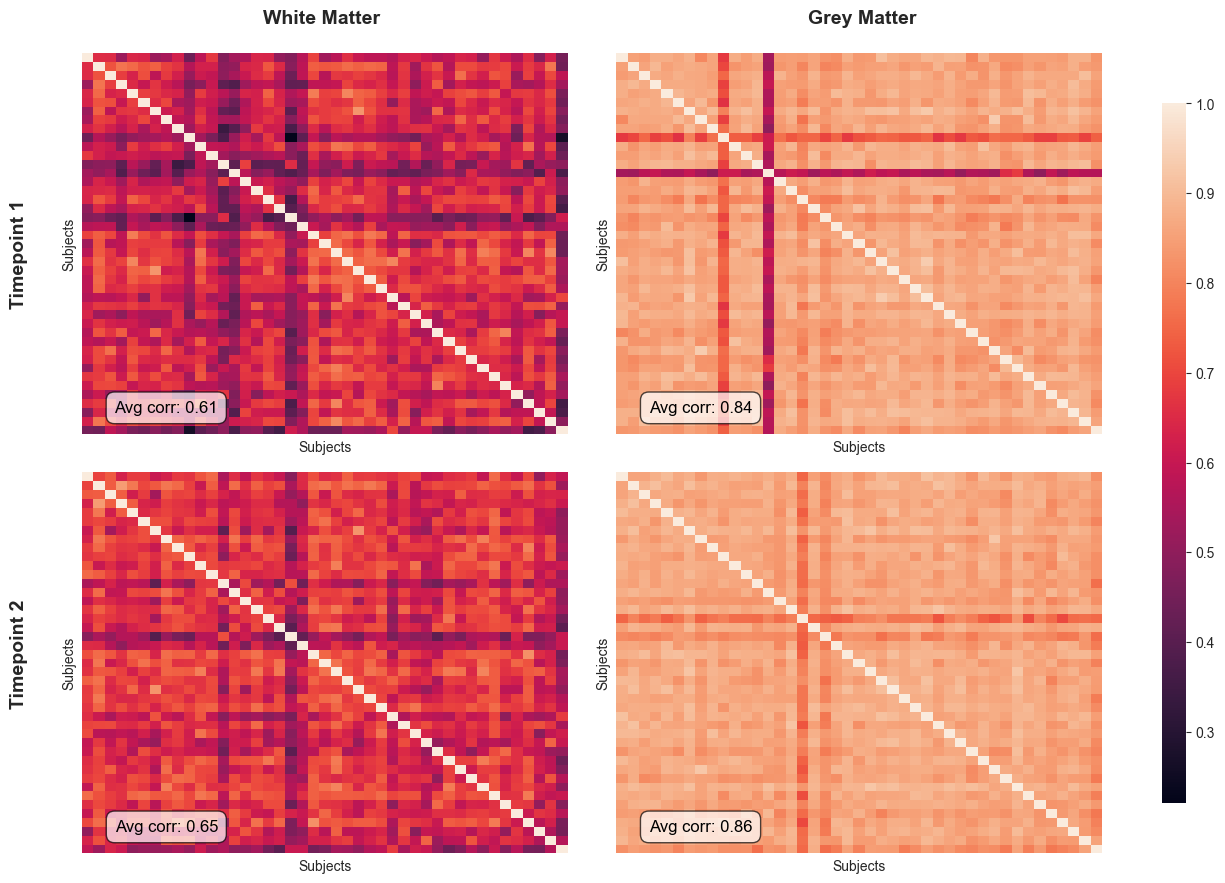

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
all_data = np.array([[t1_corr_W, t1_corr_G], [t2_corr_W, t2_corr_G]])
vmin = all_data.min()
vmax = all_data.max()

for comp, tp in product(range(2), range(2)):
    ax = axes[comp, tp]
    mat = all_data[comp][tp]
    sns.heatmap(mat, ax=ax, vmin=vmin, vmax=vmax,
                    cbar=False, xticklabels=False, yticklabels=False)
    mean_val = off_diag_mean(mat)
    ax.text(0.28, 0.05, f"Avg corr: {mean_val:.2f}",
                ha='right', va='bottom',
                transform=ax.transAxes, fontsize=12, color="black",
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5", alpha=0.7))
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  
sns.heatmap(t1_corr_W, ax=axes[0, 0], cbar=True, vmin=vmin, vmax=vmax,
            cbar_ax=cbar_ax, xticklabels=False, yticklabels=False)


fig.text(-0.01, 0.70, "Timepoint 1", va='center', rotation='vertical', fontsize=14, fontweight='bold')
fig.text(-0.01, 0.30, "Timepoint 2", va='center', rotation='vertical', fontsize=14, fontweight='bold')
fig.text(0.25, 0.93, "White Matter", ha='center', fontsize=14, fontweight='bold')
fig.text(0.70, 0.93, "Grey Matter", ha='center', fontsize=14, fontweight='bold' )
for ax in axes.flatten():
    ax.set_xlabel("Subjects")
    ax.set_ylabel("Subjects")
fig.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.show()

## Within Subject

In [7]:
number_of_subjects = t1_corr_G.shape[1]

In [8]:
corr_matrix_G = np.corrcoef(np.hstack([t1[[col for col in t1.columns if "G_" in col]].T, t2[[col for col in t2.columns if "G_" in col]].T]), rowvar=False)[:number_of_subjects, number_of_subjects:]
corr_matrix_W = np.corrcoef(np.hstack([t1[[col for col in t1.columns if "W_" in col]].T, t2[[col for col in t2.columns if "W_" in col]].T]), rowvar=False)[:number_of_subjects, number_of_subjects:] 

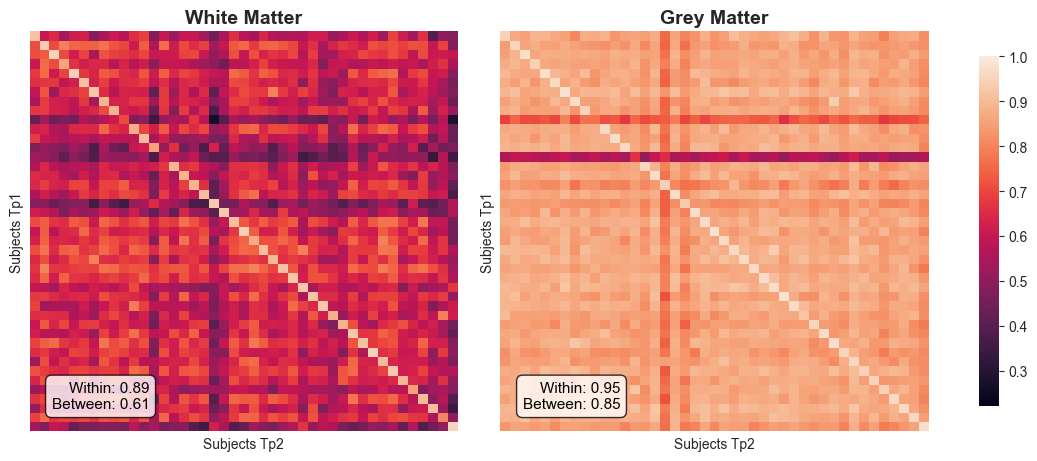

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
data = np.array([corr_matrix_W, corr_matrix_G])
vmin = all_data.min()
vmax = all_data.max()
for ax, mat, title in zip(axes, data, ["White Matter", "Grey Matter"]):
    sns.heatmap(mat, ax=ax, cbar=False, xticklabels=False, yticklabels=False,vmin=vmin, vmax=vmax)
    ax.set_title(title, fontweight='bold', fontsize=14)
    off_mean = off_diag_mean(mat)
    on_mean = diag_mean(mat)

    # display both inside a neat box
    ax.text(0.28, 0.05,
            f"Within: {on_mean:.2f}\nBetween: {off_mean:.2f}",
            ha='right', va='bottom',
            transform=ax.transAxes,
            fontsize=11, color="black",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.4", alpha=0.8))
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  
sns.heatmap(corr_matrix_W, ax=axes[0], cbar=True, vmin=vmin, vmax=vmax,
            cbar_ax=cbar_ax, xticklabels=False, yticklabels=False)
for ax in axes.flatten():
    ax.set_xlabel("Subjects Tp2")
    ax.set_ylabel("Subjects Tp1")
fig.subplots_adjust(left=0.001, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.show()

## Testing for individualisation and effect of time

### Pre process data

In [10]:
t2['time_point'] = 't2'
t1['time_point'] = 't1'
wide_df = pd.concat([t1, t2])

### Make dataframe long

In [12]:
long_df = pd.melt(wide_df, id_vars=['subject', 'time_point'], var_name='component', value_name='value')
long_df['component_num'] = long_df['component'].str.extract(r'(\d+)').astype(int)
long_df = long_df.sort_values(by=['subject', 'component_num'])
long_df['comp_type'] = long_df['component'].apply(lambda x: 'Grey' if 'G_' in x else 'White')
long_df = long_df.drop(columns='component').reset_index(drop=True)

### Split by component type

In [13]:
white_df = long_df[long_df['comp_type'].str.contains("White")].reset_index(drop=True)
grey_df = long_df[long_df['comp_type'].str.contains("Grey")].reset_index(drop=True)

### Build the heirachical models

In [15]:
grey_model = bm.Model("value ~ time_point + (1|subject)", 
                       data=grey_df,   
                       family="gaussian",
                       categorical=['subject', 'time_point'])
white_model = bm.Model("value ~ time_point + (1|subject)", 
                       data=white_df,   
                       family="gaussian",
                       categorical=['subject', 'time_point'])

#### Build the null models

In [16]:
null_grey = bm.Model("value ~ time_point", 
                       data=grey_df,   
                       family="gaussian",
                       categorical=['subject', 'time_point'])
null_white = bm.Model("value ~ time_point", 
                       data=grey_df,   
                       family="gaussian",
                       categorical=['subject', 'time_point'])

### View priors

In [17]:
white_model

       Formula: value ~ time_point + (1|subject)
        Family: gaussian
          Link: mu = identity
  Observations: 8600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.6707183442674349, sigma: 0.42238221048989083)
            time_point ~ Normal(mu: 0.0, sigma: 0.597338650579931)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.42238221048989083))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.1194677301159862)

In [18]:
grey_model

       Formula: value ~ time_point + (1|subject)
        Family: gaussian
          Link: mu = identity
  Observations: 8600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.6818838429528558, sigma: 0.5318640036011577)
            time_point ~ Normal(mu: 0.0, sigma: 0.7521692872308099)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5318640036011577))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.15043385744616197)

In [19]:
null_white

       Formula: value ~ time_point
        Family: gaussian
          Link: mu = identity
  Observations: 8600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.6818838429528558, sigma: 0.5318640036011577)
            time_point ~ Normal(mu: 0.0, sigma: 0.7521692872308099)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.15043385744616197)

In [20]:
null_grey

       Formula: value ~ time_point
        Family: gaussian
          Link: mu = identity
  Observations: 8600
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.6818838429528558, sigma: 0.5318640036011577)
            time_point ~ Normal(mu: 0.0, sigma: 0.7521692872308099)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.15043385744616197)

### Build the models

In [22]:
idata_white_model = white_model.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, Intercept, time_point, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 44 seconds.


In [23]:
idata_grey_model = grey_model.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, Intercept, time_point, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 39 seconds.


In [24]:
idata_null_grey = null_grey.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})
idata_null_white = null_white.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, Intercept, time_point]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 24 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, Intercept, time_point]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 25 seconds.


## View Model Summaries

In [25]:
az.summary(idata_white_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.671,0.004,0.664,0.678,0.0,0.0,1253.0,1809.0,1.0
time_point[t2],-0.000,0.003,-0.005,0.004,0.0,0.0,7451.0,2793.0,1.0
value_sigma,0.118,0.001,0.116,0.119,0.0,0.0,9155.0,2715.0,1.0
1|subject_sigma,0.020,0.003,0.015,0.025,0.0,0.0,1247.0,1772.0,1.0
1|subject[103818],0.007,0.008,-0.009,0.023,0.0,0.0,4686.0,3216.0,1.0
1|subject[105923],0.027,0.008,0.012,0.043,0.0,0.0,4262.0,2750.0,1.0
1|subject[111312],0.003,0.008,-0.013,0.019,0.0,0.0,4119.0,2745.0,1.0
1|subject[114823],-0.004,0.008,-0.020,0.011,0.0,0.0,4249.0,2853.0,1.0
1|subject[115320],0.018,0.009,0.001,0.033,0.0,0.0,4286.0,2508.0,1.0
1|subject[122317],-0.002,0.008,-0.016,0.014,0.0,0.0,3792.0,2793.0,1.0


In [26]:
az.summary(idata_grey_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.678,0.004,0.671,0.685,0.0,0.0,2290.0,2662.0,1.0
time_point[t2],0.007,0.003,0.001,0.013,0.0,0.0,7122.0,2853.0,1.0
value_sigma,0.149,0.001,0.147,0.151,0.0,0.0,7614.0,2623.0,1.0
1|subject_sigma,0.020,0.003,0.015,0.025,0.0,0.0,1458.0,2419.0,1.0
1|subject[103818],0.007,0.010,-0.012,0.025,0.0,0.0,5102.0,2883.0,1.0
1|subject[105923],0.007,0.010,-0.012,0.024,0.0,0.0,5923.0,2980.0,1.0
1|subject[111312],0.009,0.010,-0.009,0.027,0.0,0.0,5958.0,3241.0,1.0
1|subject[114823],-0.008,0.010,-0.026,0.009,0.0,0.0,6357.0,3071.0,1.0
1|subject[115320],0.011,0.010,-0.007,0.029,0.0,0.0,5333.0,3121.0,1.0
1|subject[122317],0.000,0.009,-0.018,0.018,0.0,0.0,5828.0,3049.0,1.0


In [29]:
az.summary(idata_null_white)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.678,0.002,0.674,0.682,0.0,0.0,3699.0,2432.0,1.0
time_point[t2],0.008,0.003,0.002,0.014,0.0,0.0,3364.0,2655.0,1.0
value_sigma,0.150,0.001,0.148,0.153,0.0,0.0,3564.0,2880.0,1.0


In [28]:
az.summary(idata_null_grey)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.678,0.002,0.674,0.682,0.0,0.0,3699.0,2432.0,1.0
time_point[t2],0.008,0.003,0.002,0.014,0.0,0.0,3364.0,2655.0,1.0
value_sigma,0.150,0.001,0.148,0.153,0.0,0.0,3564.0,2880.0,1.0


### Save Models

In [ ]:
model_dict = {"Full White model": idata_white_model, "Null White Model": idata_null_white, "Full Grey model": idata_grey_model, "Null Grey Model": idata_null_grey }

In [41]:
for model in model_dict.keys():
    file_name = "_".join(model.split())
    model_dict[model].to_netcdf((os.path.join(component_dir, f"{file_name}.nc")))

### Test for individualisation

#### Explore models

In [ ]:
print("White matter 1|subject_sigma:")
diagnostics(idata_white_model.posterior, '1|subject_sigma')

White matter 1|subject_sigma:

0.0 Inside ROPE
100.0 Outside of ROPE
0.171165499060222  effect size


In [52]:
print("White matter time_point:")
diagnostics(idata_white_model.posterior, 'time_point')

White matter time_point:
100.0 Inside ROPE
0.0 Outside of ROPE
-0.003115928962902454  effect size


In [53]:
print("Grey matter time_point:")
diagnostics(idata_grey_model.posterior, 'time_point')

Grey matter time_point:
98.9 Inside ROPE
1.100000000000001 Outside of ROPE
0.04993363302151887  effect size


In [51]:
print("Grey matter 1|subject_sigma:")
diagnostics(idata_grey_model.posterior, '1|subject_sigma')

Grey matter 1|subject_sigma:
2.775 Inside ROPE
97.225 Outside of ROPE
0.13271587601320323  effect size


#### Plot posteriors

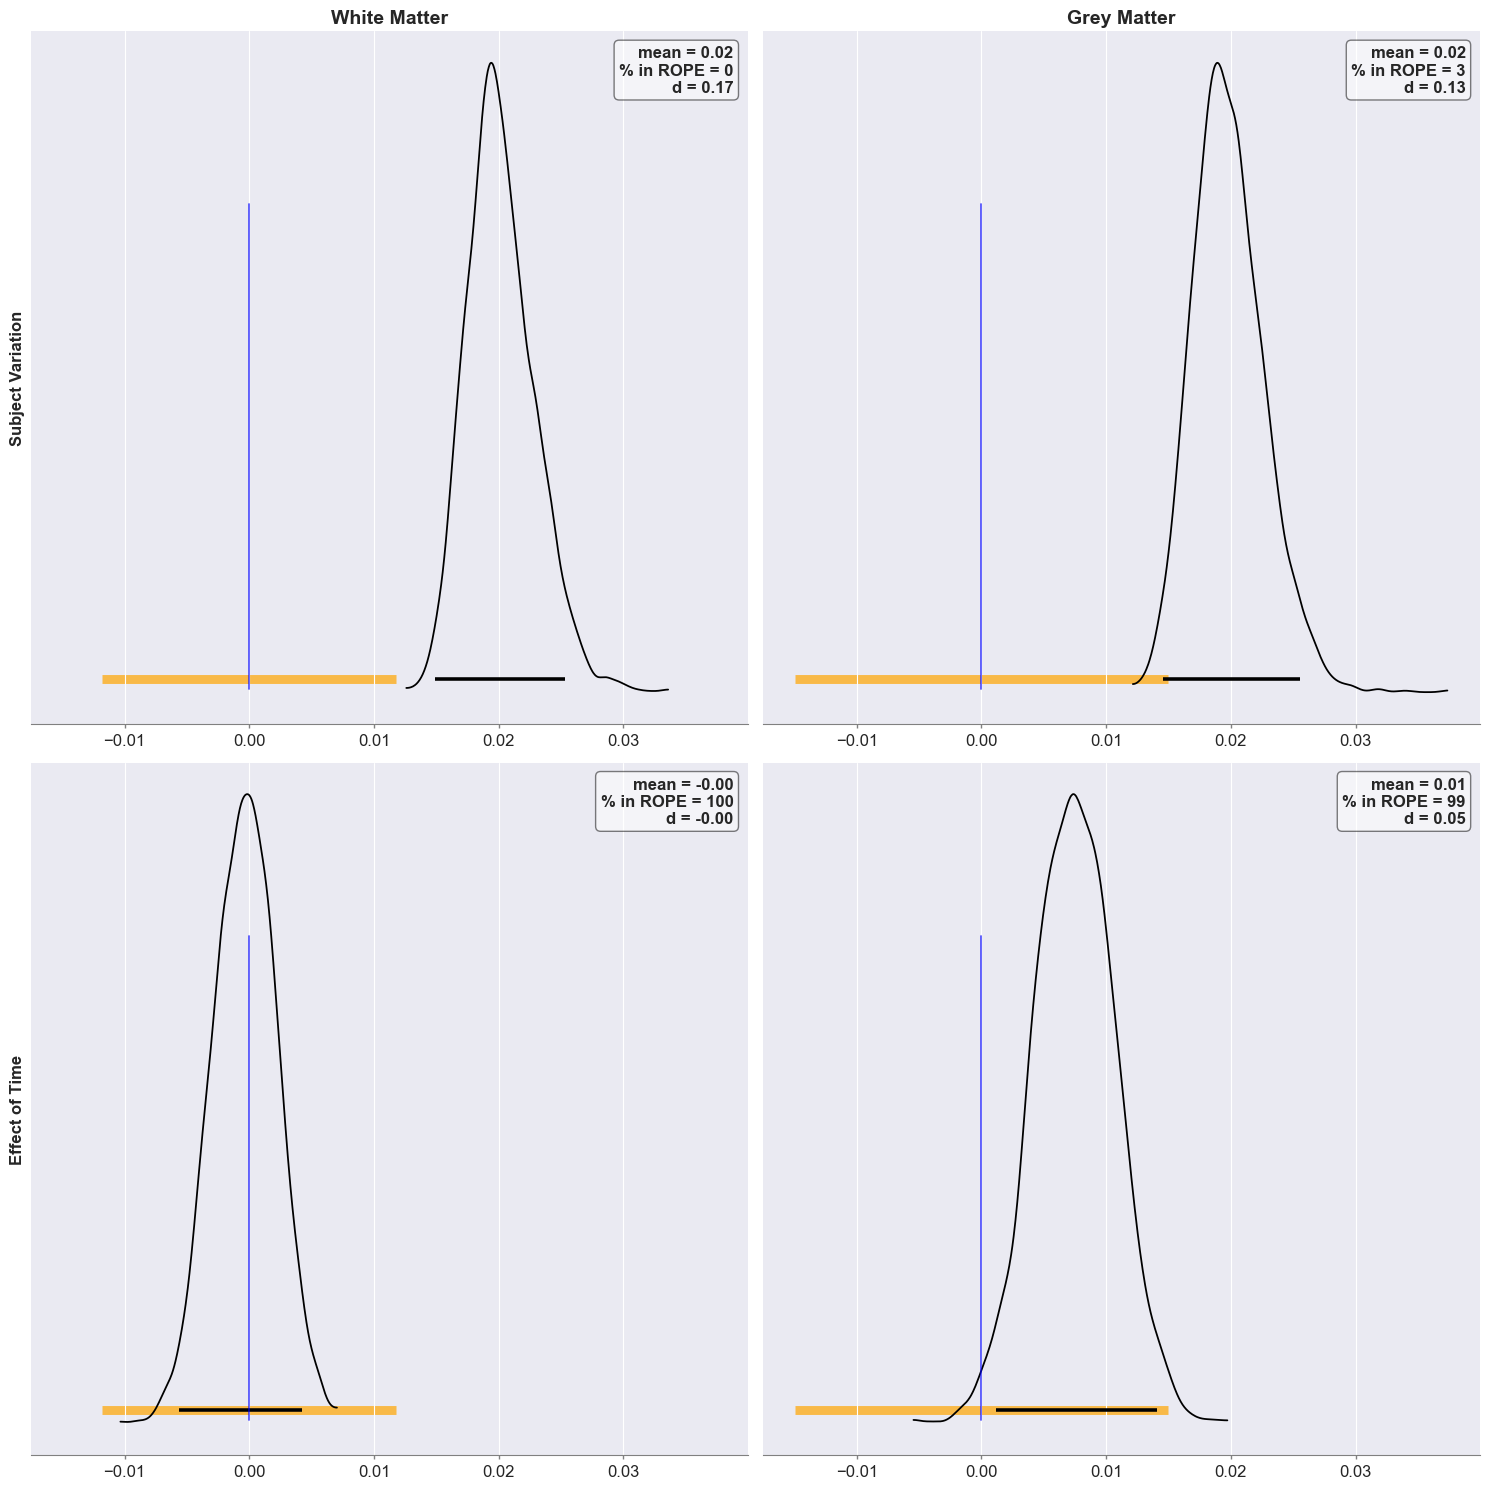

In [204]:
data_key = ['Full White model', 'Full Grey model']
titles = ["White Matter", "Grey Matter"]
params = ['1|subject_sigma', 'time_point']
param_titles = ["Subject Variation", "Effect of Time"]

fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

for col, (model_key, title) in enumerate(zip(data_key, titles)):
    model = model_dict[model_key]
    rope_width = define_rope_width(model.posterior['value_sigma'])

    for row, (param, ptitle) in enumerate(zip(params, param_titles)):
        ax = axes[row, col]
        az.plot_posterior(
            model.posterior[param],
            hdi_prob=0.95,
            rope=[-rope_width, rope_width],
            ax=ax,
            textsize=12,   # keep this to avoid breaking plot
            ref_val=0,
            color="black",
            rope_color="orange",
            ref_val_color='blue'
        )
        ax.set_title("")
        if col == 0:
            ax.set_ylabel(ptitle, fontsize=12, fontweight='bold')
        axes[0, col].set_title(title, fontweight='bold', fontsize=14)

        for txt in list(ax.texts):
            txt.remove()

        mean_val = model.posterior[param].mean().item()
        rope_pct = 100 * ((model.posterior[param] > -rope_width) & 
                          (model.posterior[param] < rope_width)).mean().item()
        effect_size = calculate_effect_size(mean_val, model.posterior['value_sigma'].mean().item())

        box_text = f"mean = {mean_val:.2f}\n% in ROPE = {rope_pct:.0f}\nd = {effect_size:.2f}"

        # add it in the top-left corner
        ax.text(
            0.98, 0.98,  # axes coordinates
            box_text,
            transform=ax.transAxes,
            ha="right",
            va="top",
            fontsize=12,
            fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="black", boxstyle="round,pad=0.3")
        )

plt.tight_layout()
plt.show()


### Compare models to see which has the most explatory value

In [205]:
comparison = az.compare(model_dict)

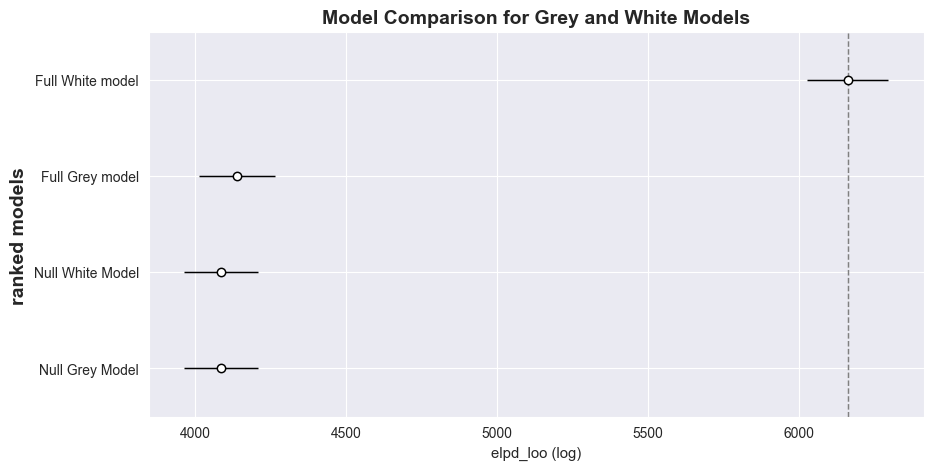

In [255]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
az.plot_compare(comparison,ax=axes, textsize=10)
axes.set_title("Model Comparison for Grey and White Models", fontsize=14, fontweight="bold")
ylabel = axes.yaxis.label
ylabel.set_horizontalalignment('right')  # keep it aligned nicely
ylabel.set_position((-0.1, 0.65))        # x moves left, y=0.5 centers vertically
ylabel.set_fontsize(14)
ylabel.set_fontweight("bold")
    #if "ranked models" in txt.get_text():
    #    #txt.set_position((-0.5, txt.get_position()[1]))  # move left
    #    #txt.set_fontsize(16)
    #    #txt.set_fontweight("bold")
plt.show()